## Get data from bucket

In [2]:
import boto3
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

In [3]:
# Define your S3 bucket and the image key
bucket_name = 'mkorphi-uibk-1'
image_key = 'cropped_images_noaugm_TrainValTest_balanced/train/loose/2011-02-02 bavaria (18)_1.jpg'

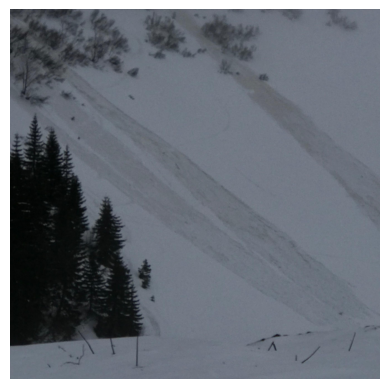

In [4]:
# Initialize a session using Amazon S3
s3 = boto3.client('s3')

# Get the image from S3
response = s3.get_object(Bucket=bucket_name, Key=image_key)
image_data = response['Body'].read()

# Open the image
image = Image.open(BytesIO(image_data))

# Plot the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

### Train Model

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
import boto3
import os

from tensorflow.keras import layers, models, regularizers

In [6]:
print(tf.__version__)

2.11.0


In [7]:
# Set the S3 bucket paths
# Set up the S3 bucket paths
s3_bucket = 'mkorphi-uibk-1'
s3_directory_key = 'cropped_images_noaugm_TrainValTest_balanced'
s3_train ='cropped_images_noaugm_TrainValTest_balanced/train'
s3_val = 'cropped_images_noaugm_TrainValTest_balanced/val'
s3_test = 'cropped_images_noaugm_TrainValTest_balanced/test'

In [8]:
# Local directory to save images
local_directory = 'local_image_directory'

# Create the local directory if it doesn't exist
if not os.path.exists(local_directory):
    os.makedirs(local_directory)


In [9]:
# Local Directory paths
local_directory = 'local_image_directory'
local_train = os.path.join(local_directory, 'train')
local_val =  os.path.join(local_directory, 'val')
local_test =  os.path.join(local_directory, 'test')

In [10]:
# Function to load datasets
def load_datasets(train_dir, val_dir, test_dir, img_size=(224, 224), batch_size=32):
    train_dataset = image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=True
    )
    
    val_dataset = image_dataset_from_directory(
        val_dir,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=False
    )
    
    test_dataset = image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=False
    )
    
    return train_dataset, val_dataset, test_dataset

In [11]:
# Load datasets
train_dataset, val_dataset, test_dataset = load_datasets(local_train, local_val, local_test)

Found 3504 files belonging to 3 classes.


2024-07-07 06:10:43.148251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-07 06:10:43.159580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-07 06:10:43.161268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-07 06:10:43.163856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebu

Found 879 files belonging to 3 classes.
Found 1098 files belonging to 3 classes.


In [26]:
# Parameters
img_height, img_width = 224, 224  # EfficientNet can handle larger images
batch_size = 32


# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
])

# Load the EfficientNetV2S model with pre-trained weights from ImageNet
base_model = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))

# Freeze the base model
base_model.trainable = False

# Add custom classification layers
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust the number of output neurons based on the number of classes
])

# Build the model
model.build(input_shape=(None, img_height, img_width, 3))

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Callbacks for early stopping, model checkpointing, and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', save_format='h5', save_weights_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# Train the model
epochs = 30

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                      

2024-07-07 06:35:20.309520: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


110/110 [==============================] - 45s 262ms/step - loss: 1.7512 - accuracy: 0.5380 - val_loss: 0.8120 - val_accuracy: 0.6177 - lr: 0.0010
Epoch 2/30
110/110 [==============================] - 27s 233ms/step - loss: 1.3877 - accuracy: 0.5716 - val_loss: 0.7420 - val_accuracy: 0.7008 - lr: 0.0010
Epoch 3/30
110/110 [==============================] - 26s 226ms/step - loss: 1.1544 - accuracy: 0.5862 - val_loss: 0.7350 - val_accuracy: 0.6746 - lr: 0.0010
Epoch 4/30
110/110 [==============================] - 27s 234ms/step - loss: 0.9861 - accuracy: 0.6082 - val_loss: 0.6575 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 5/30
110/110 [==============================] - 26s 224ms/step - loss: 0.8936 - accuracy: 0.6287 - val_loss: 0.6666 - val_accuracy: 0.7167 - lr: 0.0010
Epoch 6/30
110/110 [==============================] - 26s 225ms/step - loss: 0.8969 - accuracy: 0.6230 - val_loss: 0.6979 - val_accuracy: 0.7144 - lr: 0.0010
Epoch 7/30
110/110 [==============================] - 26s 223ms

In [27]:
print(model)

## Analyze Results

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [29]:
## Load Best Model
best_model = model

In [30]:
# Evaluate on test dataset
test_loss, test_acc = best_model.evaluate(test_dataset, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Generate predictions for the test dataset
test_predictions = best_model.predict(test_dataset)
test_predictions = np.argmax(test_predictions, axis=1)

# Extract true labels from the test dataset
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)

35/35 - 6s - loss: 0.6740 - accuracy: 0.7231 - 6s/epoch - 165ms/step

Test accuracy: 0.7231329679489136
35/35 [==============================] - 9s 168ms/step


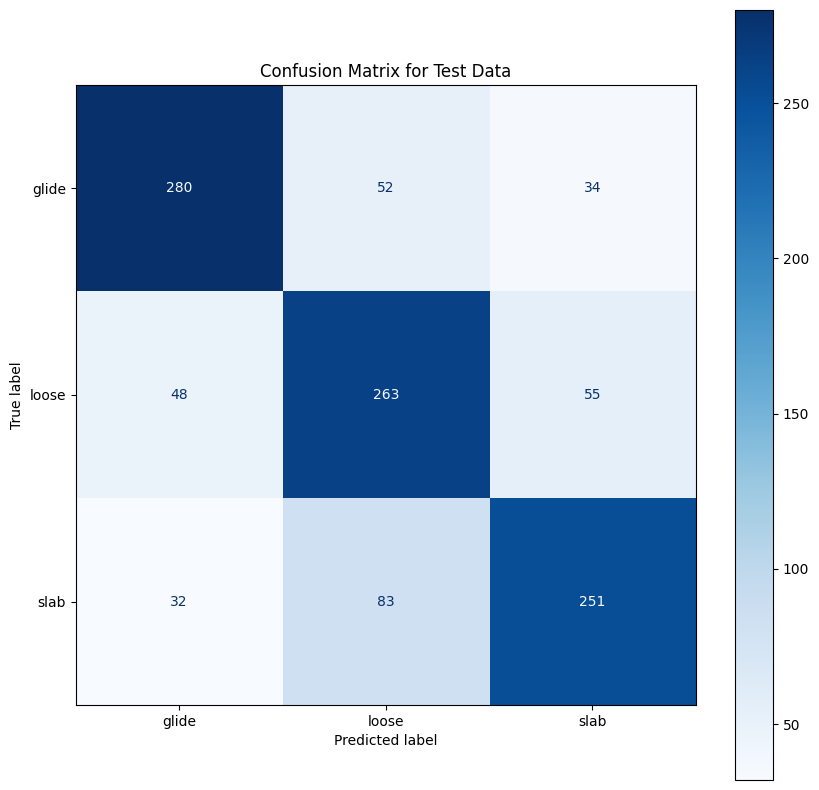

In [31]:
# Compute the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix with a customized color map
fig, ax = plt.subplots(figsize=(10, 10))
cmd = ConfusionMatrixDisplay(cm, display_labels=test_dataset.class_names)
cmd.plot(ax=ax, cmap='Blues')  # Use the 'Blues' colormap
plt.title('Confusion Matrix for Test Data')
plt.show()



In [32]:
# Compute the classification report including F1-score
class_report = classification_report(test_labels, test_predictions, target_names=test_dataset.class_names)
print('\nClassification Report:\n', class_report)


Classification Report:
               precision    recall  f1-score   support

       glide       0.78      0.77      0.77       366
       loose       0.66      0.72      0.69       366
        slab       0.74      0.69      0.71       366

    accuracy                           0.72      1098
   macro avg       0.73      0.72      0.72      1098
weighted avg       0.73      0.72      0.72      1098



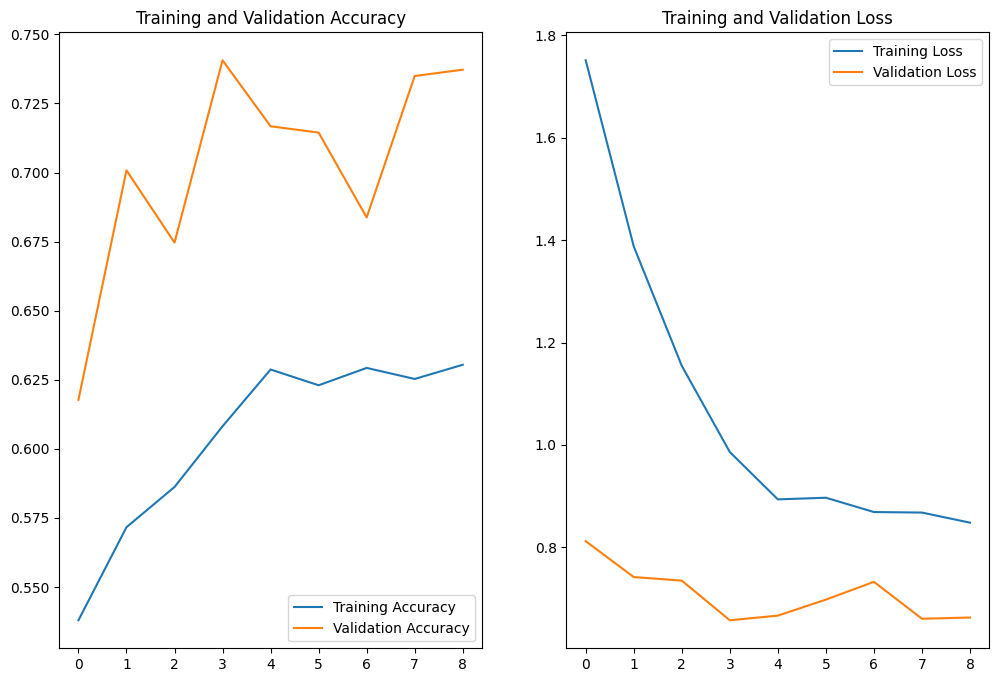

In [33]:
# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # Use the length of the history data to ensure the dimensions match

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Misclassified images

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

In [81]:
# Predict probabilities and classes
predictions = test_predictions
predicted_labels = test_predictions
true_labels = test_labels

In [89]:
# Find indices of misclassified images and categorize them by true and predicted labels
misclassified_indices = np.where(predicted_labels != true_labels)[0]
misclassified_images = np.array(list(test_dataset.unbatch().as_numpy_iterator()))[misclassified_indices]
misclassified_true_labels = true_labels[misclassified_indices]
misclassified_predicted_labels = predicted_labels[misclassified_indices]

/tmp/ipykernel_17/2719623181.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  misclassified_images = np.array(list(test_dataset.unbatch().as_numpy_iterator()))[misclassified_indices]


In [91]:
# Create a dictionary to store misclassified images by each true/predicted label pair
misclassified_by_type = {}
for true_label, predicted_label in zip(misclassified_true_labels, misclassified_predicted_labels):
    label_pair = (true_label, predicted_label)
    if label_pair not in misclassified_by_type:
        misclassified_by_type[label_pair] = []

    # Find the corresponding image for this misclassification
    #print(true_label)
    #print(predicted_label)
        indices = np.where((misclassified_true_labels == true_label) & (misclassified_predicted_labels == predicted_label))[0]
        for idx in indices:
            misclassified_by_type[label_pair].append(misclassified_images[idx])
    #print(idx)
        #misclassified_by_type[label_pair].append(misclassified_images[idx])

In [93]:
#Sanity check with confusion matrix
print(len(misclassified_by_type[0,1]))
print(len(misclassified_by_type[0,2]))
print(len(misclassified_by_type[1,0]))
print(len(misclassified_by_type[2,0]))

21
58
31
27


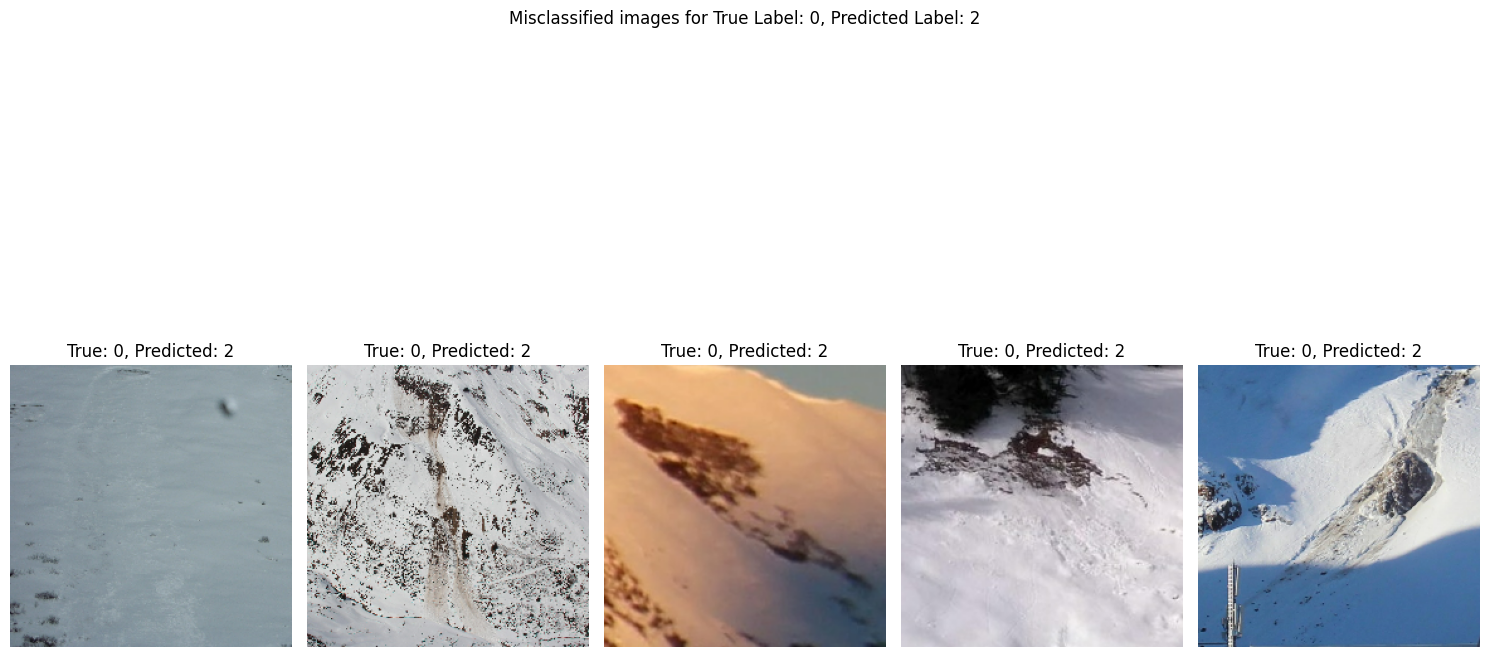

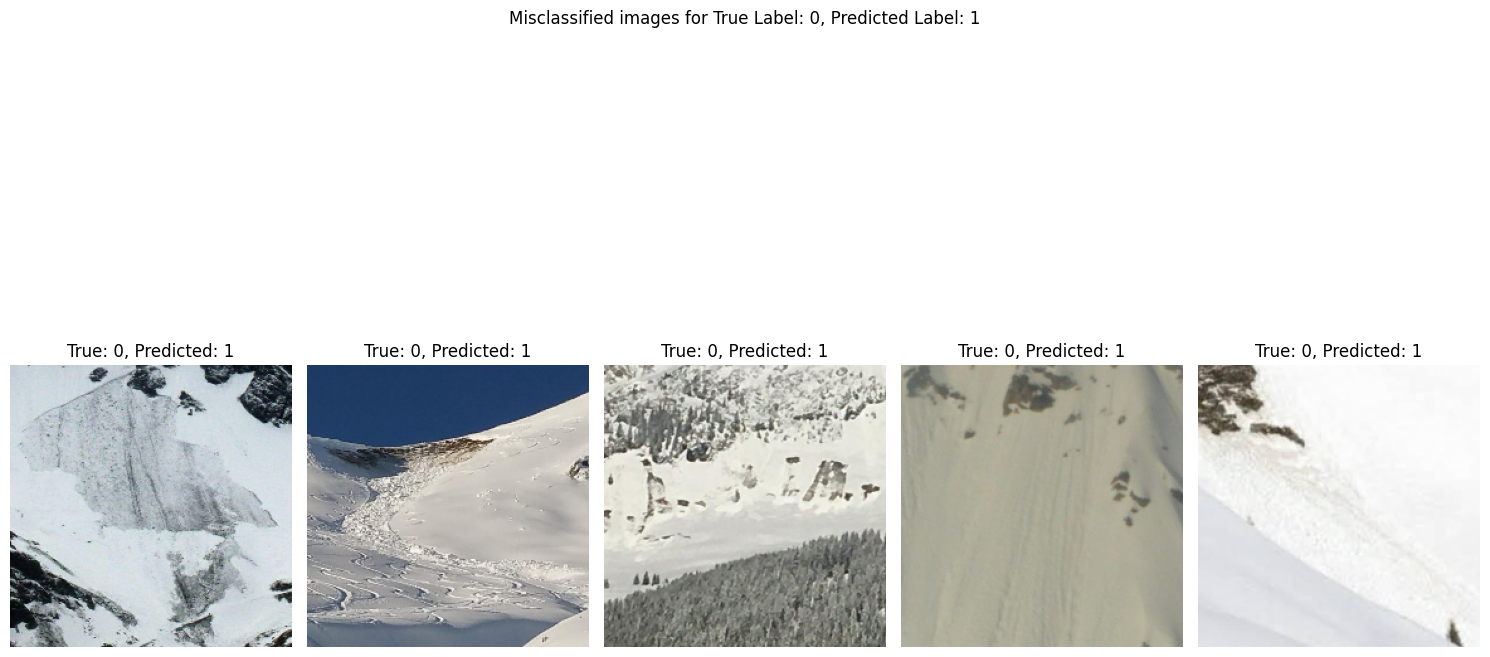

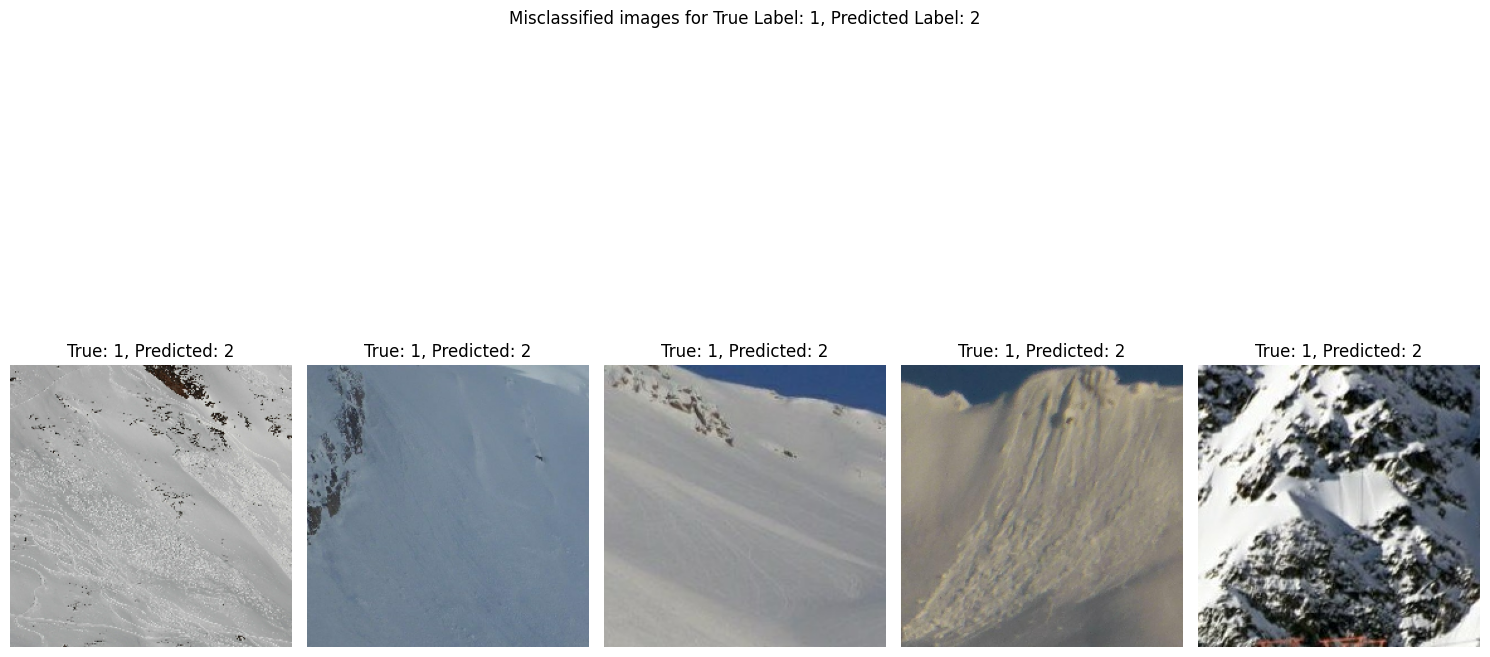

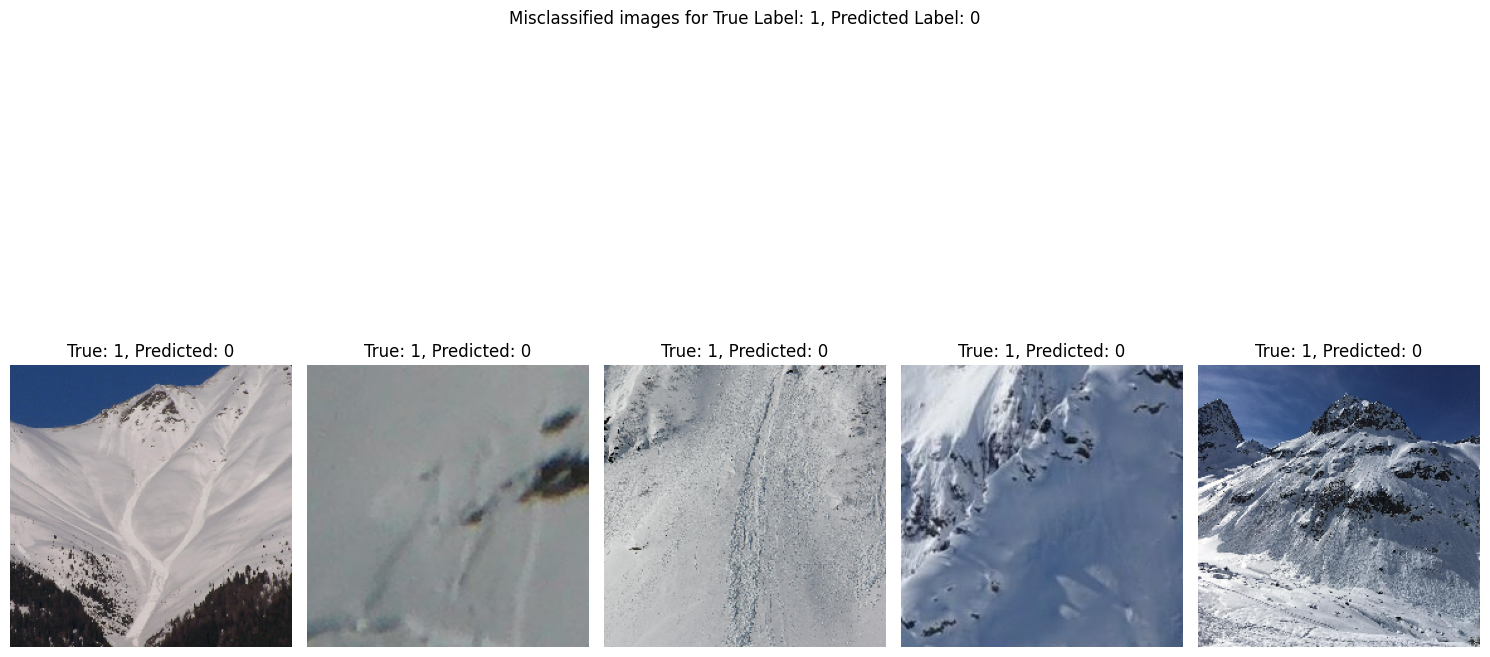

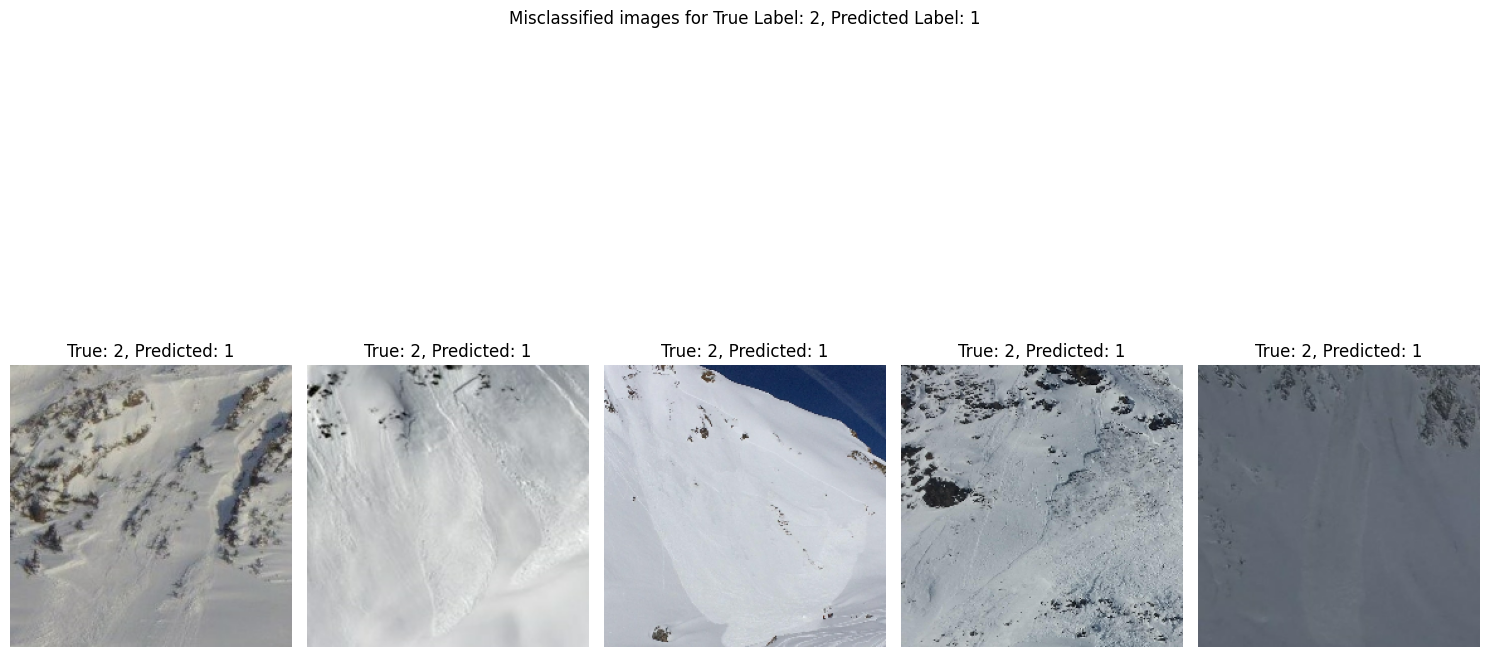

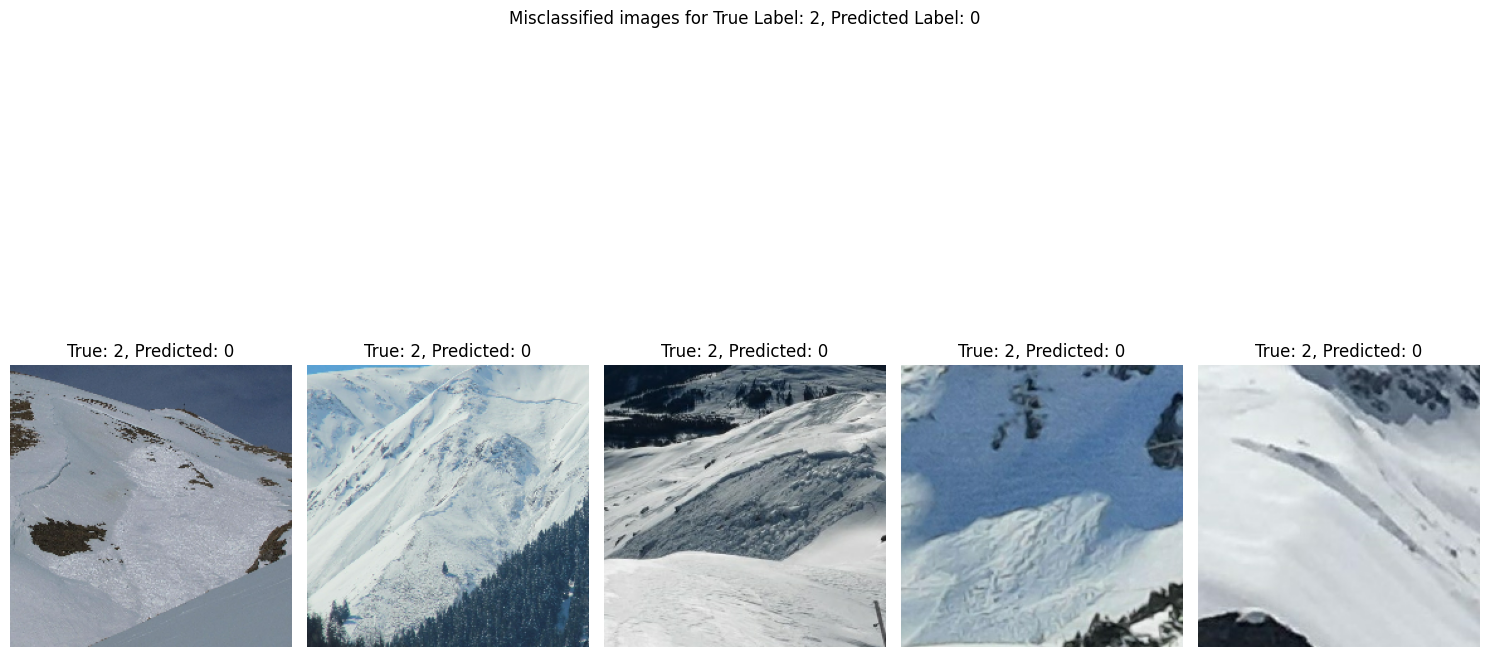

In [94]:
# Visualize misclassified images for each unique true/predicted label pair
num_samples_per_pair = 5  # Number of samples to display per pair
for i, (label_pair, images) in enumerate(misclassified_by_type.items()):
    true_label, predicted_label = label_pair

    plt.figure(figsize=(15, 10))
    for j, image in enumerate(images[:num_samples_per_pair]):
        # Display the image
        plt.subplot(1, num_samples_per_pair, j + 1)
        plt.imshow(image[0].astype(np.uint8))  # Assuming image is in uint8 format
        plt.title(f"True: {true_label}, Predicted: {predicted_label}")
        plt.axis('off')

    plt.suptitle(f"Misclassified images for True Label: {true_label}, Predicted Label: {predicted_label}")
    plt.tight_layout()
    plt.show()